In [82]:
import xarray as xr
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
from global_land_mask import globe
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [83]:

#path = '/home/rakshith/Desktop/Total moisture BoB/*.nc'
#path = '/home/rakshith/Desktop/Total moisture India/*.nc'
path = '/media/rakshith/Seagate Expansion Drive/Total moisture India/*.nc'

In [84]:
ds = xr.open_mfdataset(path)

In [85]:
ds1 = ds.where(mask1>0).mean(dim=['latitude', 'longitude'])
dqdx = ds1.groupby('time.year').mean('time')
dqdx=-dqdx*86400

Text(0.5, 0, 'Year')

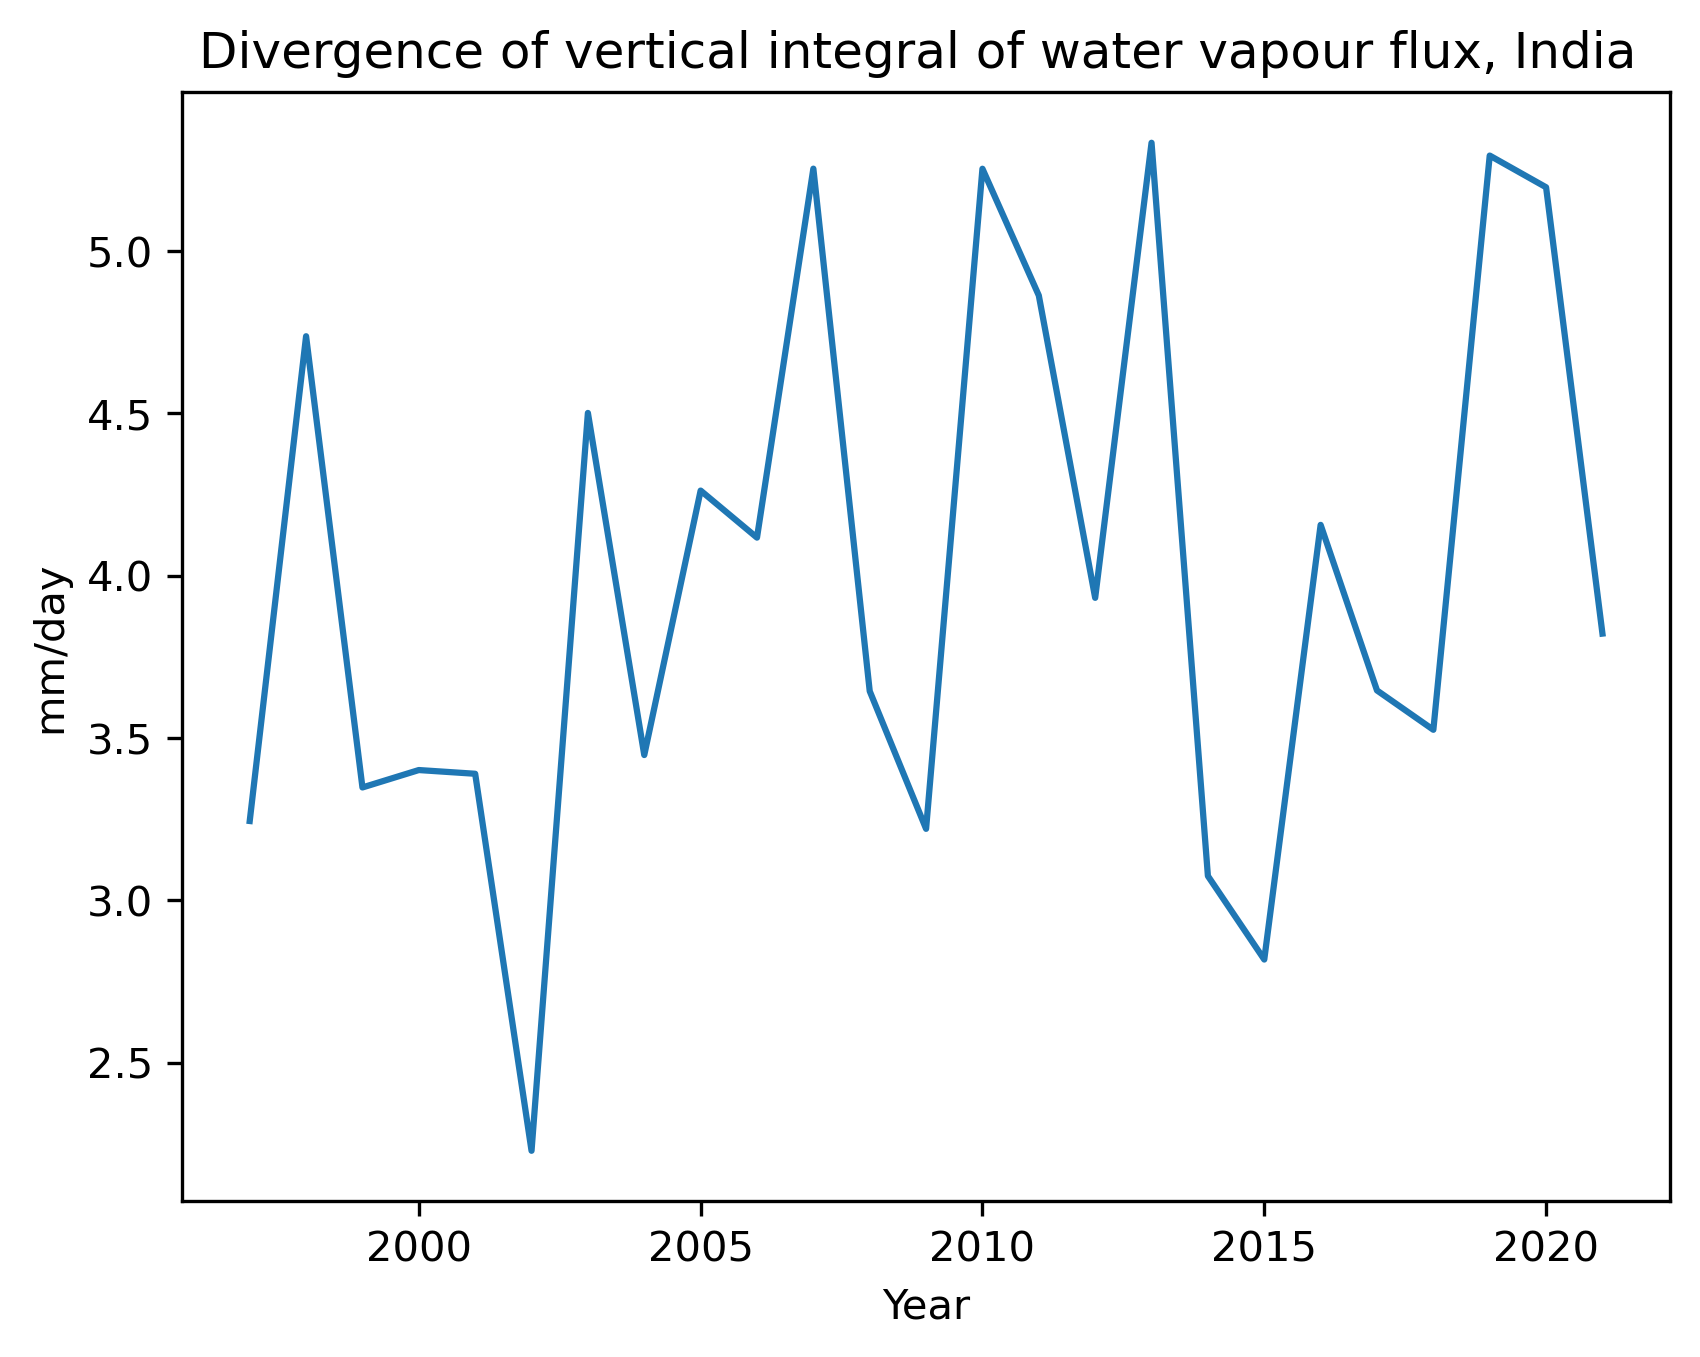

In [86]:
dqdx.wvdiv.plot()
#dmdx.wvfle.plot()
#dmdx.tefle.plot()
plt.title('Divergence of vertical integral of water vapour flux, India ')
plt.ylabel('mm/day')
plt.xlabel('Year')

In [57]:
#path2 = '/home/rakshith/mraks/ERA Prec, Pwat all region.nc'
path2 = '/media/rakshith/Seagate Expansion Drive/mraks/ERA Prec, Pwat all region.nc'

In [58]:
ds2 = xr.open_dataset(path2)

In [59]:
sliced = ds2.sel(latitude=slice(30, 10), longitude=slice(70,90), time=slice('1997', '2021'))

lon_grid1, lat_grid1 = np.meshgrid(sliced.longitude, sliced.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

In [60]:
jjas = sliced.time.dt.month.isin(range(6, 10)) #JJAS
clim = sliced.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
P = clim.mtpr.where(mask1>0).mean(dim=['latitude', 'longitude'])

In [61]:
#path3 = '/home/rakshith/Desktop/ERA5 Evaporation.nc'
path3 = '/media/rakshith/Seagate Expansion Drive/mraks/ERA5 Evaporation.nc'

In [62]:
ds3 = xr.open_dataset(path3)
sliced2 = ds3.sel(latitude=slice(30, 10), longitude=slice(70,90), time=slice('1997', '2021'))
jjas = sliced2.time.dt.month.isin(range(6, 10)) #JJAS
clim2 = sliced2.sel(time=jjas)
clim2 = clim2.groupby('time.year').mean('time')
E = clim2.mer.where(mask1>0).mean(dim=['latitude', 'longitude'])

In [63]:
PE = 86400*(P+E)

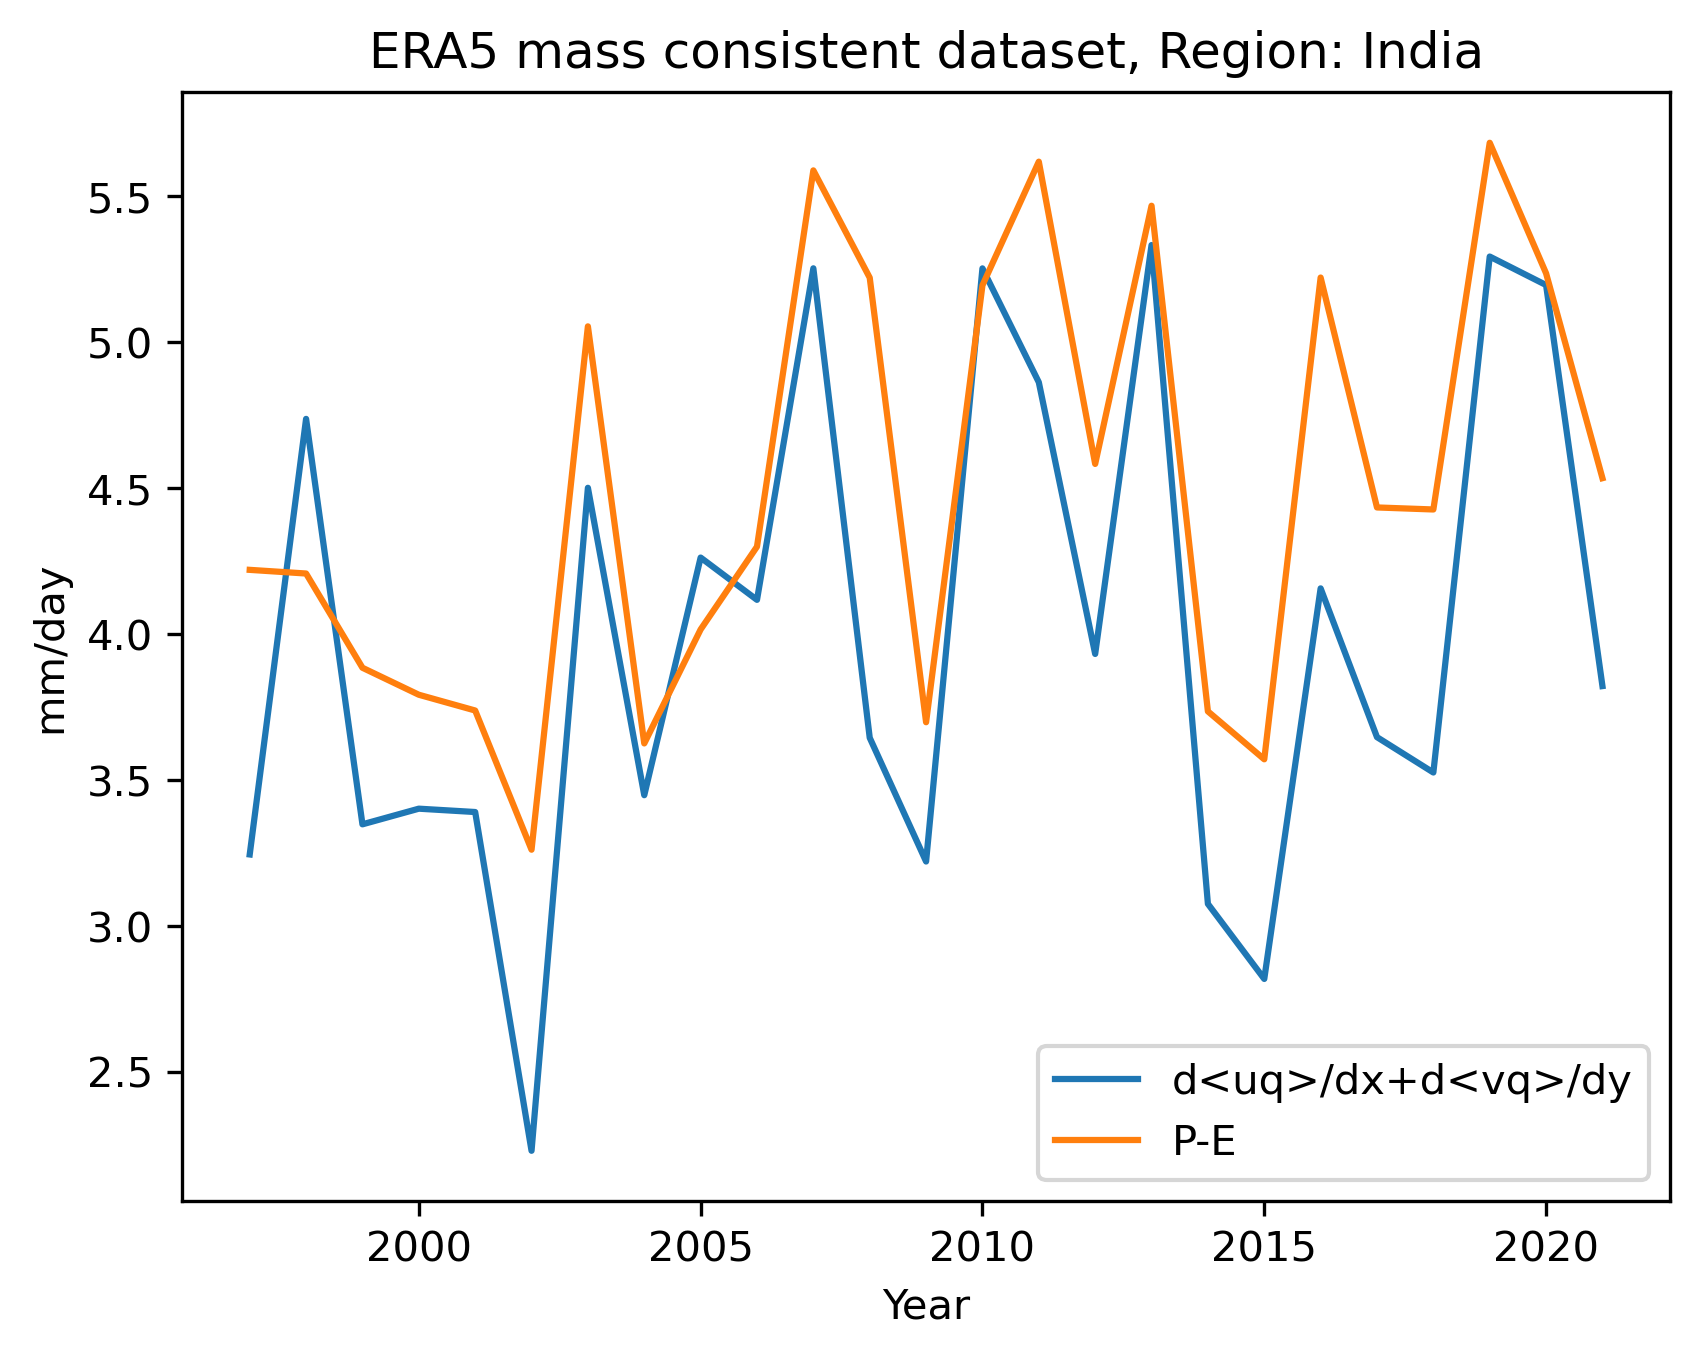

In [64]:
dqdx.wvdiv.plot(label='d<uq>/dx+d<vq>/dy')
PE.plot(label='P-E')
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title('ERA5 mass consistent dataset, Region: India')
plt.legend()

In [65]:
residue = dqdx.wvdiv-PE

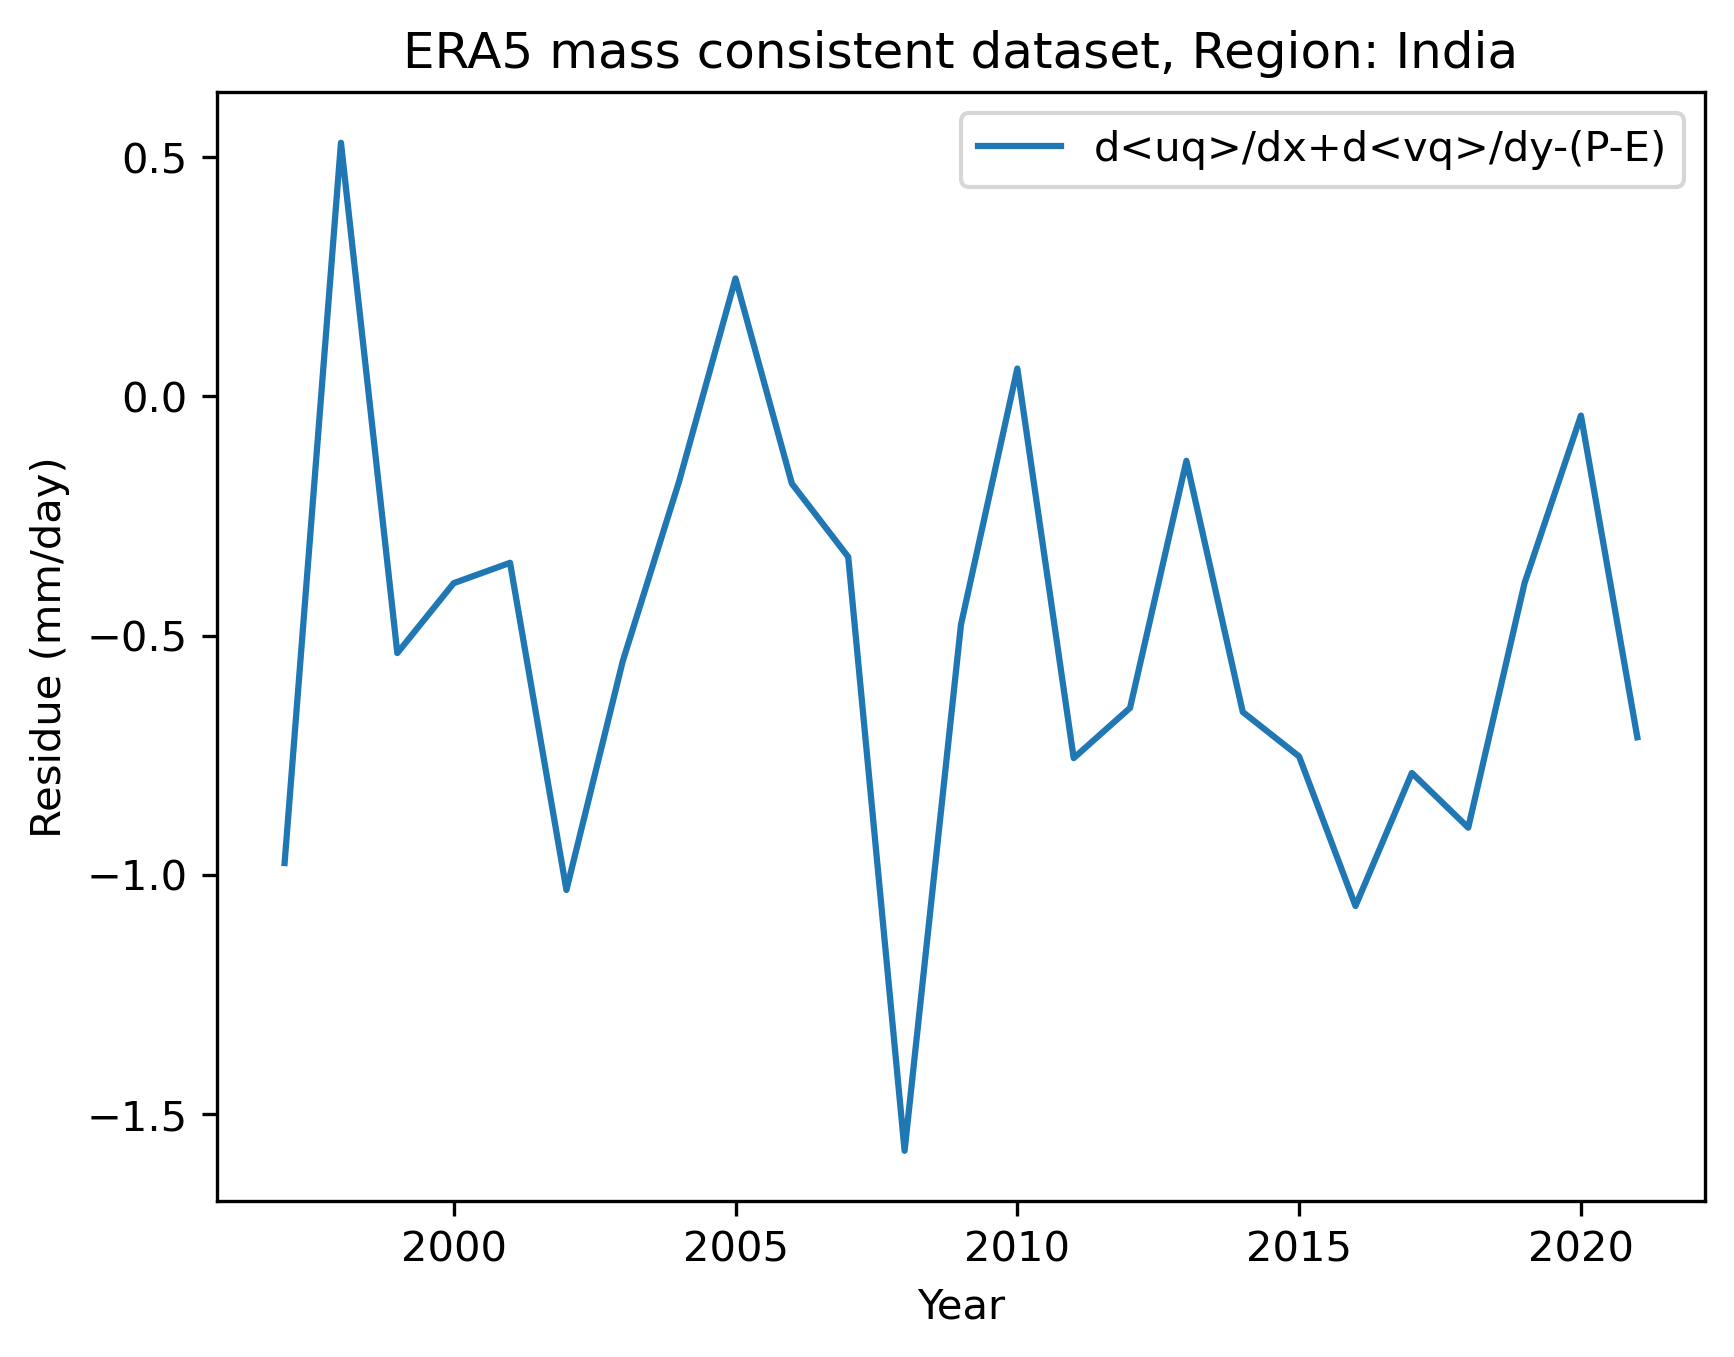

In [88]:
residue.plot(label='d<uq>/dx+d<vq>/dy-(P-E)')
plt.xlabel('Year')
plt.ylabel('Residue (mm/day)')
plt.title('ERA5 mass consistent dataset, Region: India')
plt.legend()

# Own calculations

In [19]:
g = 9.80616 #Avg. gravity acceleration on Earth
Cp = 1004.64 #Specific heat at constant pressure for dry air
Lv = 2.501e6 #Latent heat of vaporization for liquid water at 0C

## Moisture budget

In [20]:
d = '/media/rakshith/Seagate Expansion Drive/mraks/ERA TGMS all variables India.nc'
ds7 = xr.open_dataset(d)
jjas = ds7.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds7.sel(time=jjas)
ds7 = clim.groupby('time.year').mean('time')

lon_grid1, lat_grid1 = np.meshgrid(ds7.longitude, ds7.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

In [21]:
import warnings;
warnings.filterwarnings('ignore');

In [22]:
spind = '/media/rakshith/Seagate Expansion Drive/mraks/ERA surface pressure India.nc'
ds10 = xr.open_dataset(spind)
jjas = ds10.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds10.sel(time=jjas)
ds11 = clim.sp.groupby('time.year').mean('time')/100

In [23]:
#q advection terms
x=ds7.level
xs= np.arange(1, 1001, 1)
qhadvind=[] #horizontal advection
qwadvind=[] #vertical advection
for j in ds7.year:
    ds8 = ds7.sel(year=j)
    ps1 = ds11.sel(year=j)
    q = ds8.q
    wadv = mpcalc.advection(q, w=ds8.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qwadvind.append(integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(q, u=ds8.u, v=ds8.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    qhadvind.append(100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))

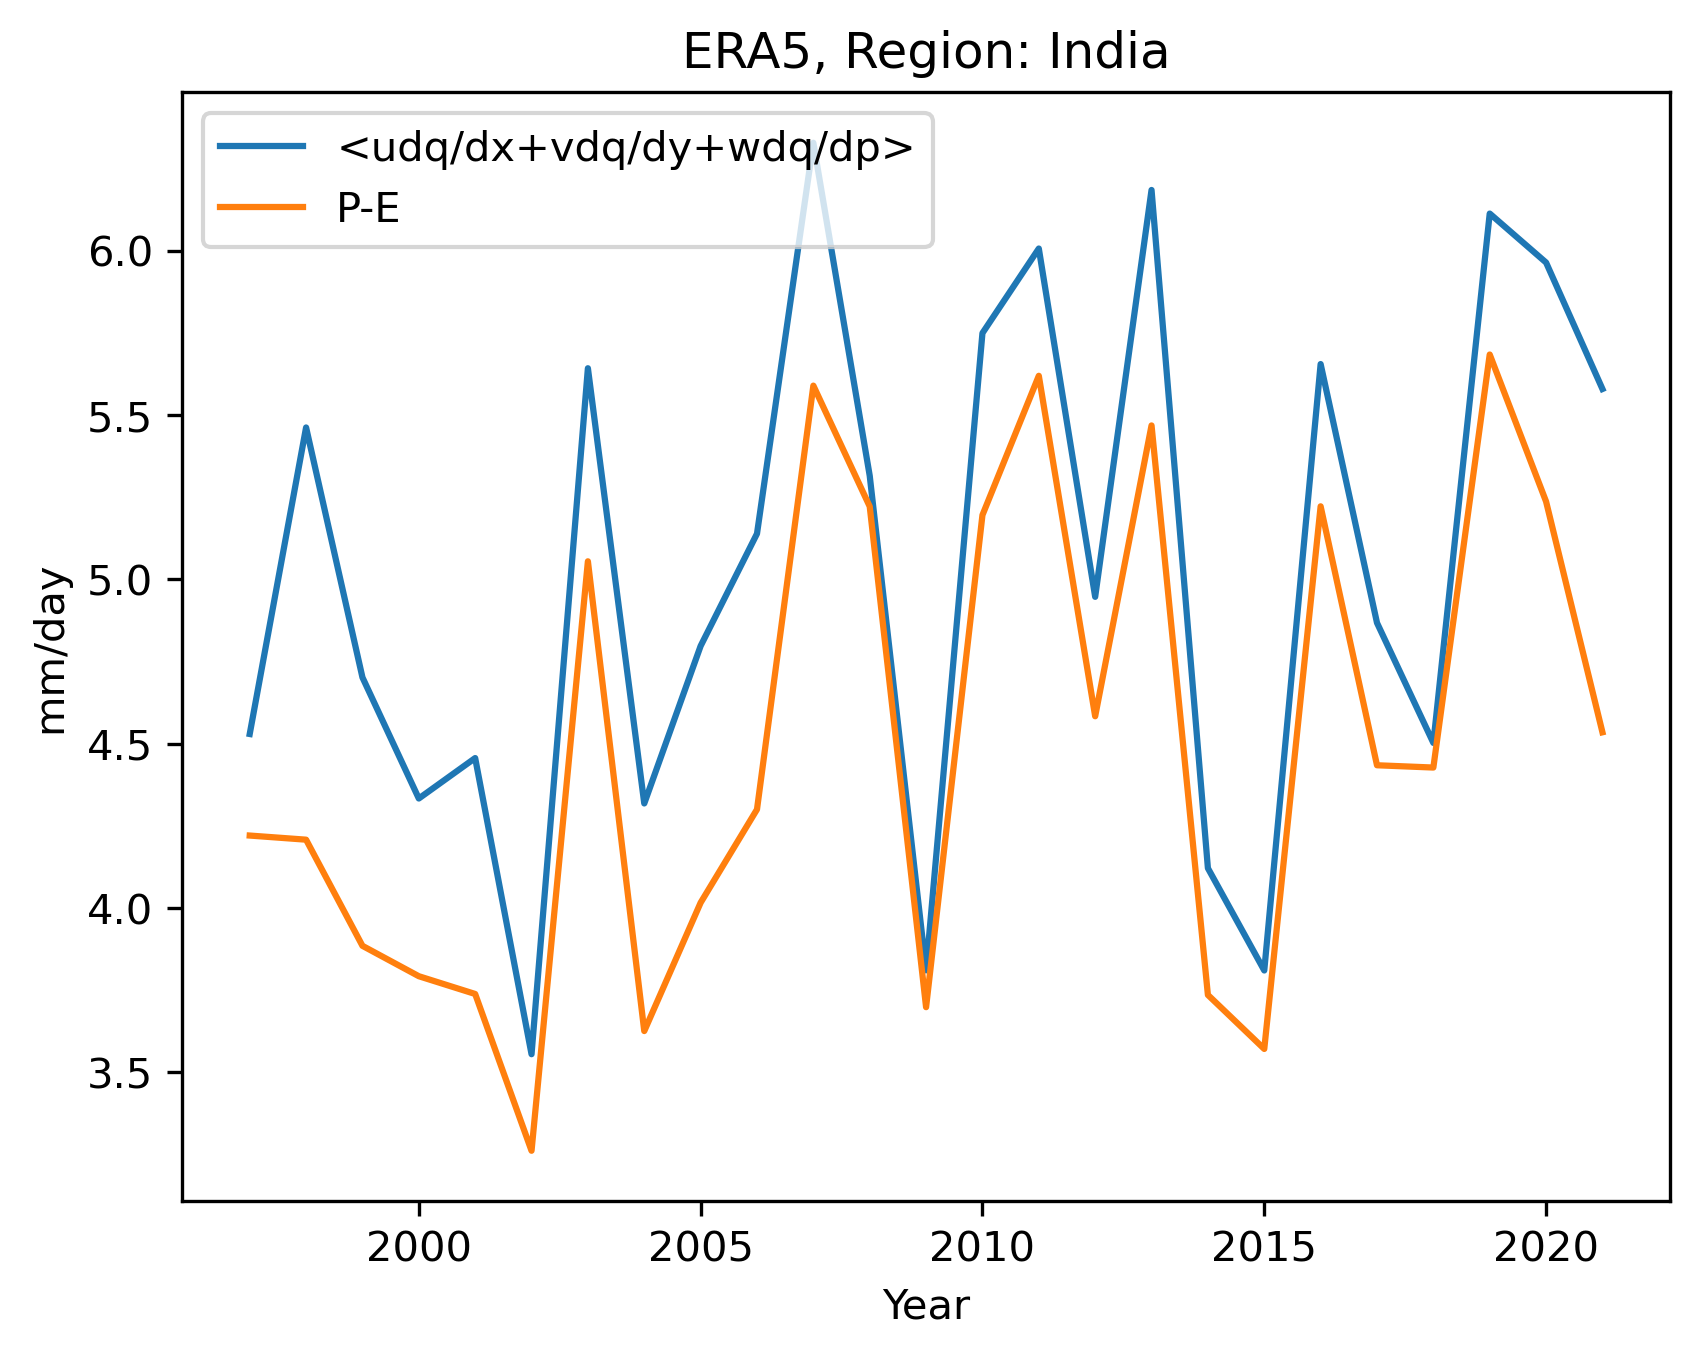

In [24]:
#plt.plot(X, np.multiply(86400, qwadvind)[38:], label='<wdq/dp>')
X = np.arange(1997, 2022, 1)
plt.plot(X, np.multiply(86400, np.add(qhadvind, qwadvind))[38:], label='<udq/dx+vdq/dy+wdq/dp>')
PE.plot(label='P-E')
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title('ERA5, Region: India')
plt.legend()

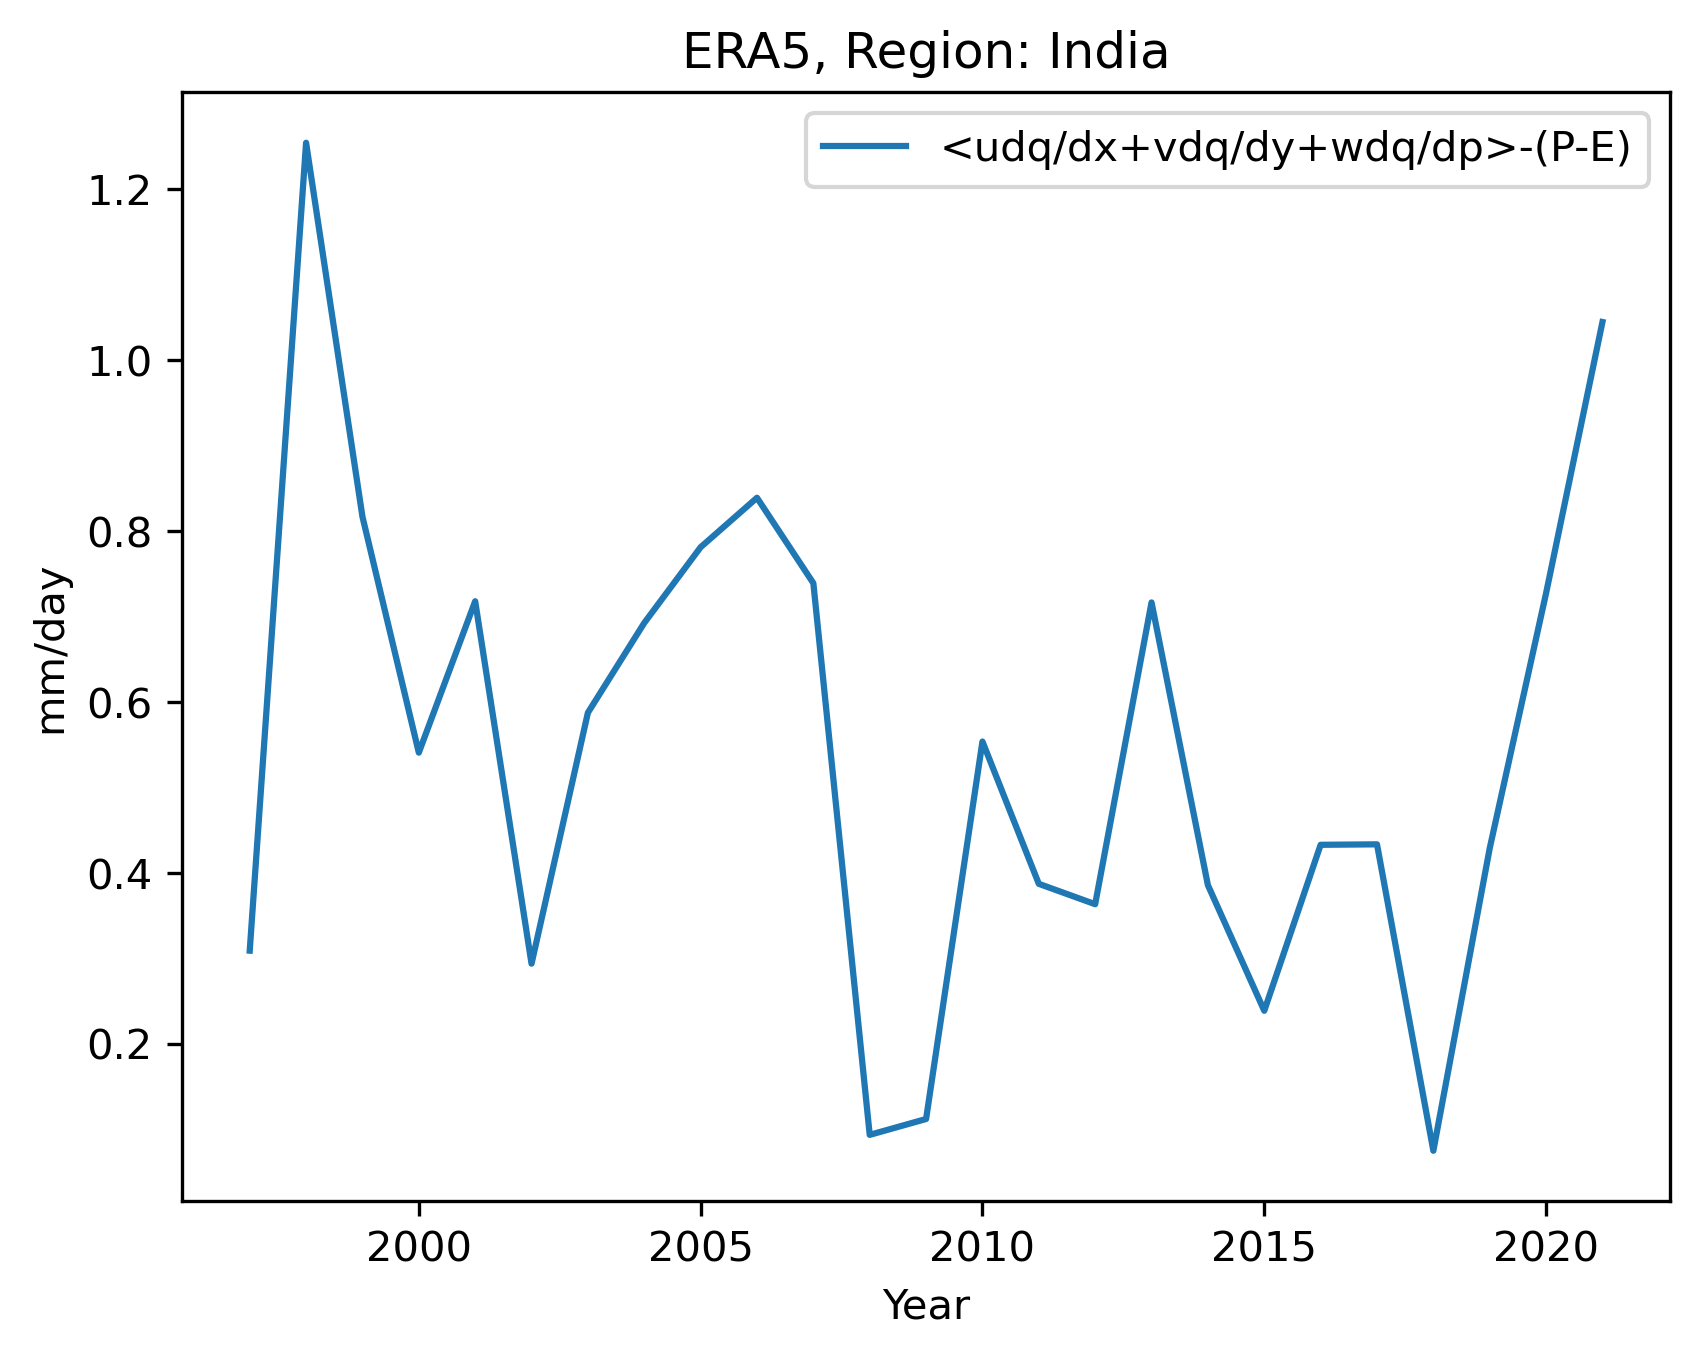

In [25]:
plt.plot(X, np.multiply(86400, np.add(qhadvind, qwadvind))[38:]-PE, label='<udq/dx+vdq/dy+wdq/dp>-(P-E)')
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title('ERA5, Region: India')
plt.legend()

Text(0.5, 1.0, 'Moisture budget over India, Corr: 0.93')

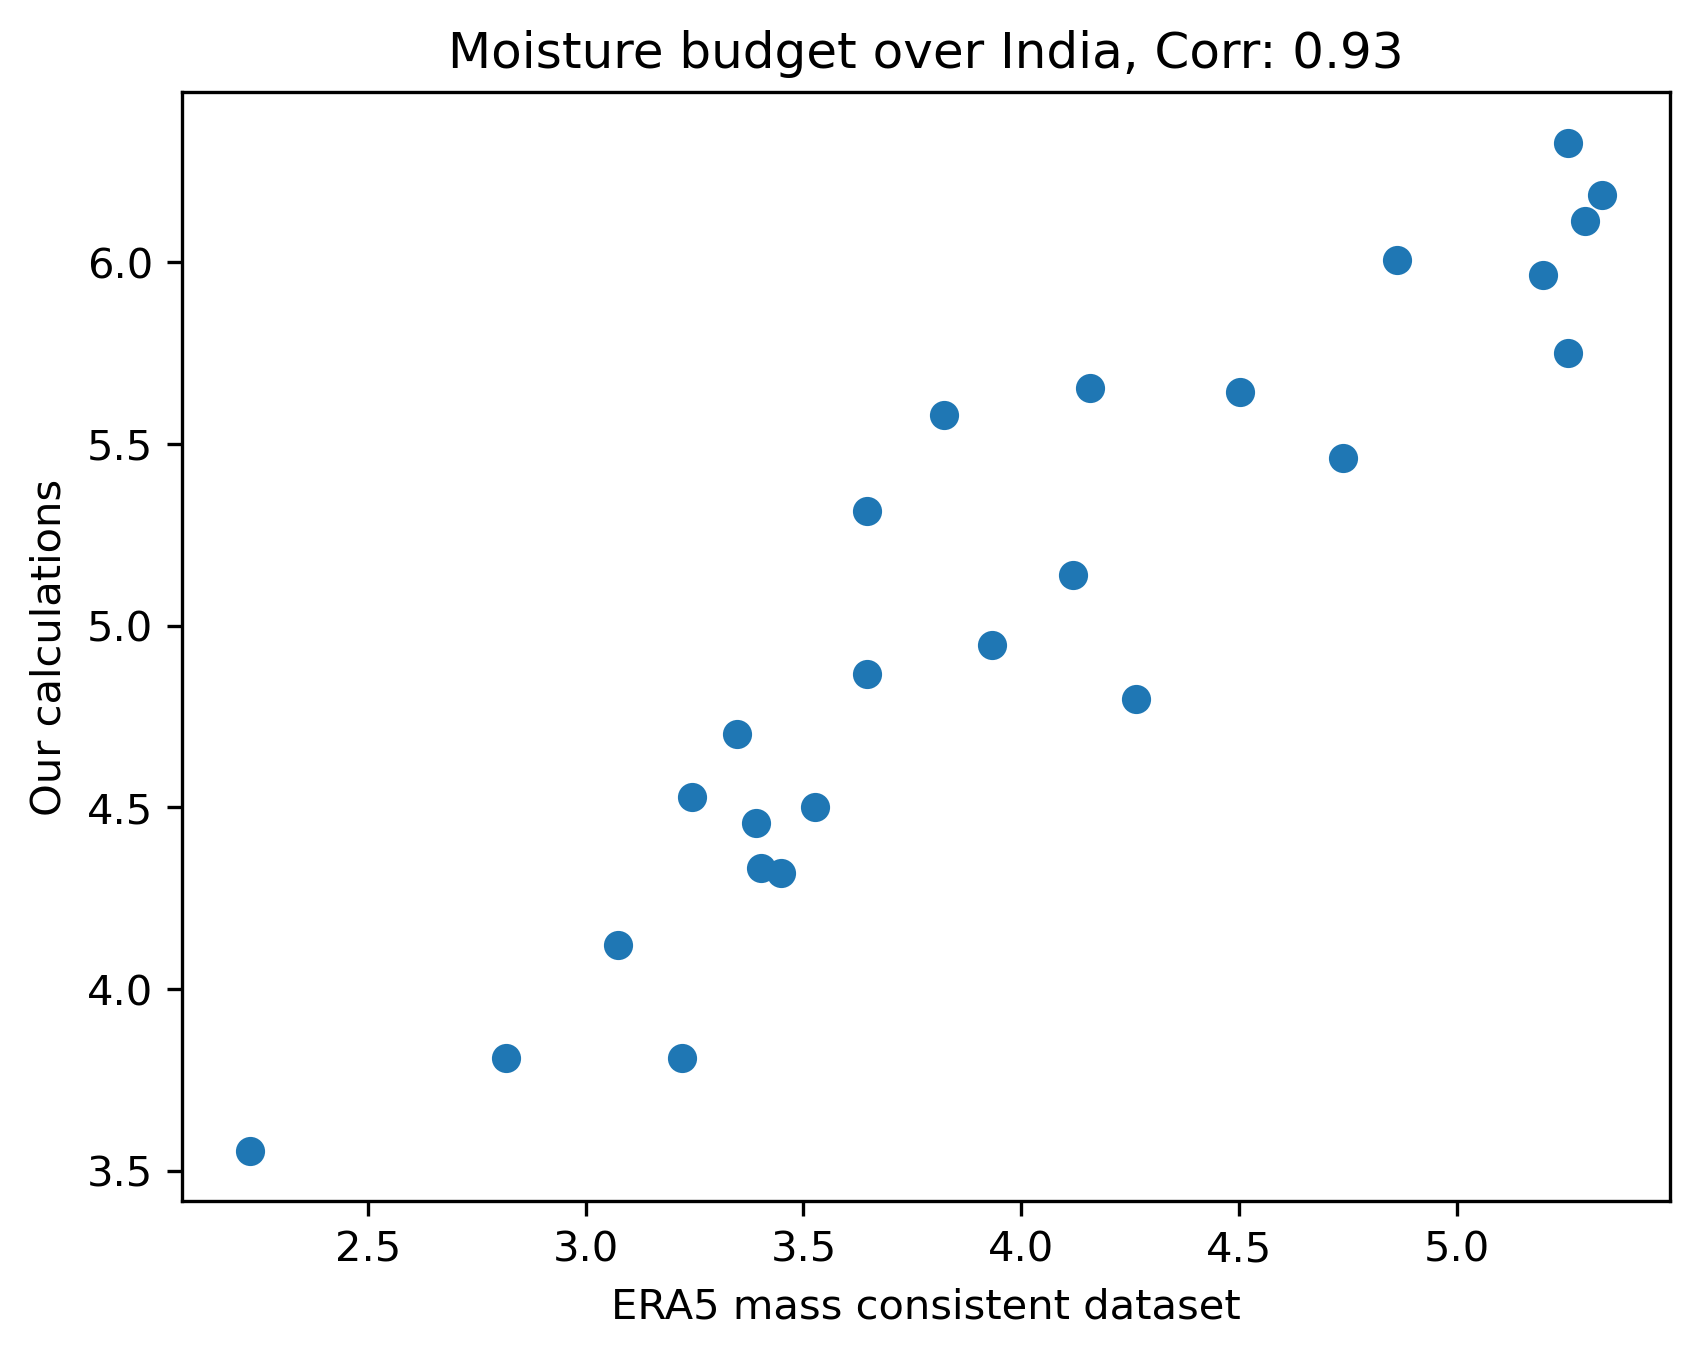

In [89]:
plt.scatter(dqdx.wvdiv, np.multiply(86400, np.add(qhadvind, qwadvind))[38:])
np.corrcoef(dqdx.wvdiv, np.multiply(86400, np.add(qhadvind, qwadvind))[38:])
plt.ylabel('Our calculations')
plt.xlabel('ERA5 mass consistent dataset')
plt.title('Moisture budget over India, Corr: 0.93')

## Energy budget

In [27]:
#MSE advection terms
x=ds7.level
xs= np.arange(1, 1001, 1)
hadvind=[] #horizontal advection
wadvind=[] #vertical advection
uadvind=[]
for j in ds7.year:
    ds8 = ds7.sel(year=j)
    ps1 = ds11.sel(year=j)
    m = Cp*ds8.t + Lv*ds8.q + ds8.z
    wadv = mpcalc.advection(m, w=ds8.w)
    inter = wadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    wadvind.append(-1*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    hadv = mpcalc.advection(m, u=ds8.u, v=ds8.v)
    inter = hadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    hadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))
    uadv = mpcalc.advection(m, u=ds8.u)
    inter = uadv.interp(level=xs, method="cubic")
    selected = inter.where(inter.level < ps1)
    grid = selected.fillna(0)
    integral = grid.integrate('level')/g
    uadvind.append(-100*integral.where(mask1>0).mean(dim=['latitude', 'longitude']))

In [28]:
h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
#h = '/media/rakshith/Windows/Users/mraks/TGMS ERA 1959-2021, India only.nc'
ds4 = xr.open_dataset(h)
jjas = ds4.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds4.sel(time=jjas)
clim = clim.groupby('time.year').mean('time')
clim3 = clim.where(mask1>0).mean(dim=['latitude', 'longitude'])

In [76]:
Qdiv = clim3.mtnswrf + clim3.mtnlwrf + clim3.mslhf + clim3.msshf + clim3.msnswrf + clim3.msnlwrf

# Budget from mass consistent data

In [77]:
en = '/media/rakshith/Seagate Expansion Drive/Total energy India/*.nc'
ds5 = xr.open_mfdataset(en)

In [78]:
ds6 = ds5.where(mask1>0).mean(dim=['latitude', 'longitude'])
dmdx = ds6.groupby('time.year').mean('time')

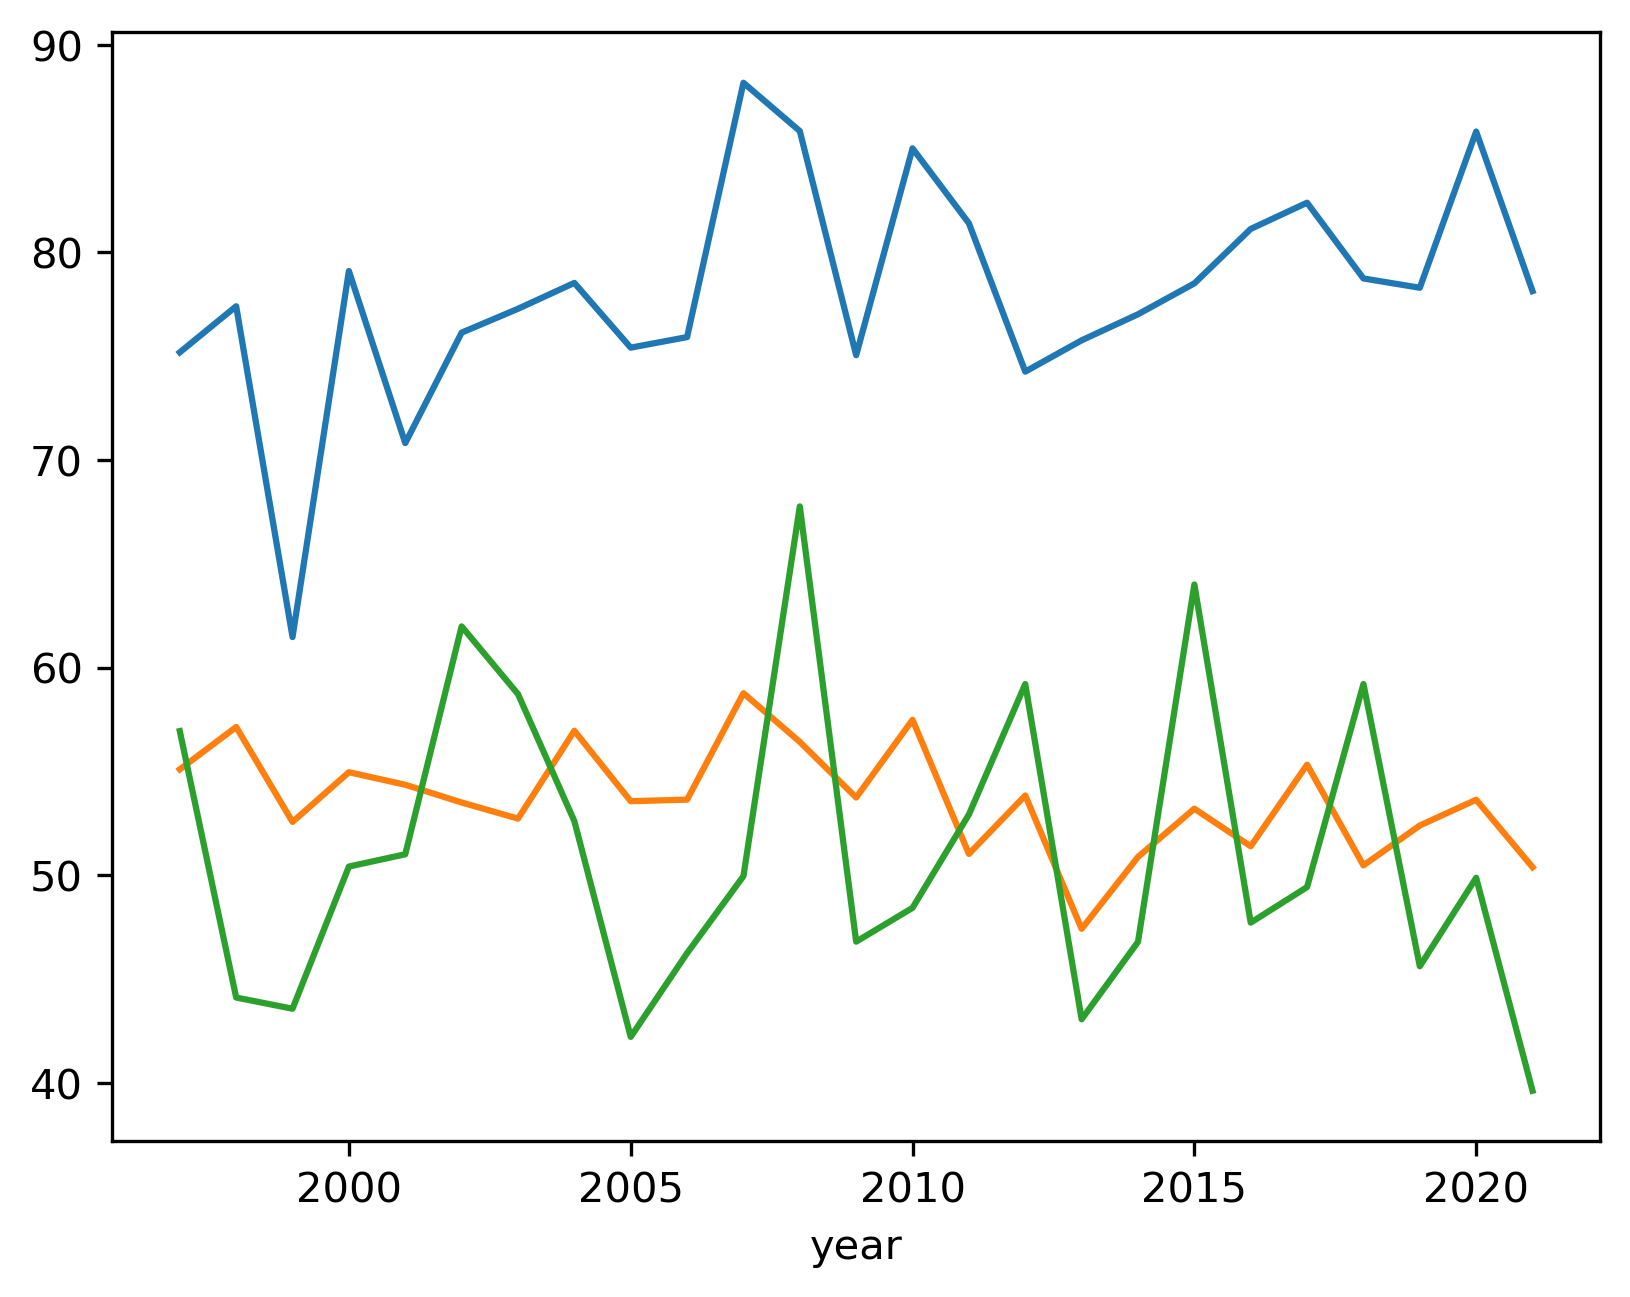

In [79]:
dmdx.tediv.plot()
Qdiv[38:].plot()
plt.plot(X, np.add(hadvind, wadvind)[38:])

# Residue check

In [42]:
path4 = '/home/rakshith/mraks/ERA TGMS all variables India.nc'

In [89]:
ds4 = xr.open_dataset(path4)

In [91]:
lats = ds4['latitude'].metpy.unit_array
lons = ds4['longitude'].metpy.unit_array

In [92]:
dx, dy = mpcalc.lat_lon_grid_deltas(lons,lats)

In [99]:
dx.shape

(81, 80)

In [132]:
# (lat, lon)
du = np.subtract(ds4.u.sel(longitude=slice(70, 90)), ds4.u.sel(longitude=slice(70.25, 90)))

In [133]:
ds4.u.sel(longitude=slice(70, 89.75)).shape

(252, 37, 81, 80)

In [137]:
ds4.u.sel(longitude=slice(70, 89.75)) - ds4.u.sel(longitude=slice(70.25, 90))[:,:,:,:,None]

IndexError: too many indices